<a href="https://colab.research.google.com/github/paigeyeung/exowatch-colab/blob/master/DanielZsSearchVSXfromFITSwithKaleeMods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install and Import
%%capture
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pip install git+https://github.com/rzellem/EXOTIC.git --ignore-requires-python
!pip install -r https://raw.githubusercontent.com/rzellem/EXOTIC/main/requirements.txt

from exotic.exotic import NASAExoplanetArchive, get_wcs, find_target
import re
import os
import json
import requests
from json import dumps
from pathlib import Path
from astropy.io.fits import PrimaryHDU, getdata, getheader
from tenacity import retry, retry_if_exception_type, retry_if_result, \
    stop_after_attempt, wait_exponential


def is_false(value):
    return value is False


def result_if_max_retry_count(retry_state):
    pass


class PlateSolution:

    def __init__(self, file=None, directory=None, api_key=None,
                 api_url='http://nova.astrometry.net/api/'):
        if api_key is None:
            api_key = {'apikey': 'vfsyxlmdxfryhprq'}
        self.api_url = api_url
        self.api_key = api_key
        self.file = file
        self.directory = directory

    def plate_solution(self):
        session = self._login()
        if not session:
            return PlateSolution.fail('Login')

        sub_id = self._upload(session)
        if not sub_id:
            return PlateSolution.fail('Upload')

        sub_url = self._get_url(f"submissions/{sub_id}")
        job_id = self._sub_status(sub_url)
        if not job_id:
            return PlateSolution.fail('Submission ID')

        job_url = self._get_url(f"jobs/{job_id}")
        download_url = self.api_url.replace("/api/", f"/wcs_file/{job_id}/")
        wcs_file = Path(self.directory) / "wcs.fits"
        wcs_file = self._job_status(job_url, wcs_file, download_url)
        if not wcs_file:
            return PlateSolution.fail('Job Status')
        else:
            print("WCS file creation successful.")
            return wcs_file

    def _get_url(self, service):
        return self.api_url + service

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10),
           retry=(retry_if_result(is_false) | retry_if_exception_type(requests.exceptions.RequestException)),
           retry_error_callback=result_if_max_retry_count)
    def _login(self):
        r = requests.post(self._get_url('login'), data={'request-json': dumps(self.api_key)})
        if r.status_code >= 400:
            return False
        elif r.json()['status'] == 'success':
            return r.json()['session']
        return False

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10),
           retry=(retry_if_result(is_false) | retry_if_exception_type(requests.exceptions.RequestException)),
           retry_error_callback=result_if_max_retry_count)
    def _upload(self, session):
        files = {'file': open(self.file, 'rb')}
        headers = {'request-json': dumps({"session": session}), 'allow_commercial_use': 'n',
                   'allow_modifications': 'n', 'publicly_visible': 'n'}

        r = requests.post(self.api_url + 'upload', files=files, data=headers)

        if r.json()['status'] == 'success':
            return r.json()['subid']
        return False

    @retry(stop=stop_after_attempt(20), wait=wait_exponential(multiplier=1, min=4, max=10),
           retry=(retry_if_result(is_false) | retry_if_exception_type(requests.exceptions.RequestException)),
           retry_error_callback=result_if_max_retry_count)
    def _sub_status(self, sub_url):
        r = requests.get(sub_url)
        if r.json()['job_calibrations']:
            return r.json()['jobs'][0]
        return False

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10),
           retry=(retry_if_result(is_false) | retry_if_exception_type(requests.exceptions.RequestException)),
           retry_error_callback=result_if_max_retry_count)
    def _job_status(self, job_url, wcs_file, download_url):
        r = requests.get(job_url)
        if r.json()['status'] == 'success':
            r = requests.get(download_url)
            with wcs_file.open('wb') as f:
                f.write(r.content)
            hdu = PrimaryHDU(data=getdata(filename=self.file), header=getheader(filename=wcs_file))
            hdu.writeto(wcs_file, overwrite=True)
            return wcs_file
        return False

    @staticmethod
    def fail(error_type):
        print("WARNING: After multiple attempts, a plate solution was not forthcoming from nova.astrometry.net"
              f" due to {error_type}. Sorry!")
        return False

# Notebook code to read in a FITS file that has already been plate solved and look for variable stars 
# in the VSX database in the field and then to find AAVSO comp stars in the field. 
# The results are displayed on the image
#
# Definition of a function to use the VSX API and parse the VOTABLE results
# this code comes from a note posted Sat, 12/15/2018 - 13:55 in the AAVSO forums by stratis (Nigel Banks, Worcester, GB)
# the code was slightly modified by Daniel Zaharevitz 1/2021 to make it run under python 3
# it would probably be worth checking into using the astroquery library to do the VOTABLE parsing to have 
# better maintained code

# get_vsx_data
#
# Returns the results of a query to the AAVSO VSX API to retrieve target data.
#
# Input:    url         VSX API url. Defaults to http://www.aavso.org/vsx/index.php
#           params      VSX API query parameters. Defaults to query.votable view.
#                       Additional parameters defined here: https://www.aavso.org/direct-web-query-vsxvsp
#
# Output:   List of dictionary objects with one dictionary per target (star)
#           returned by the VSX API. Dictionaries keyed by the VSX field id. 
#
# This function uses the BeautifulSoup HTTP/XML parser:
from bs4 import BeautifulSoup as bs
import requests
from io import StringIO

def get_vsx_data(url = "http://www.aavso.org/vsx/index.php",
                 params = {'view': 'query.votable',
                           'vtype': 'ep'}   # ep for test purposes only to limit results
                          ):
    
    response = requests.get(url,params=params)
    if (response.status_code > 400):
        raise Exception(response.status_code, response.reason)
    votableXML = StringIO()        # Create in-memory file
    votableXML.write(response.text)   # Save response to in-memory file
    soup = bs(votableXML.getvalue(), "xml") # Parse using BeautifulSoup

    # Load field definitions, checking for missing or duplicate ids
    fields = soup.find_all("FIELD")
    for field in fields:
        if field["id"] is None:
            raise Exception("Field has no id.")
        elif len(soup.select('FIELD[id=%s]' % field["id"])) != 1:
            raise Exception("Duplicate field id.")

    # Build list of dictionaries, one dict per row (star), indexed by field id
    rows = soup.find_all("TR")
    results = []
    for row in rows:
        row_dict = {}
        row_fields = row.find_all("TD")
        if len(row_fields) != len(fields):
            # No. of TD elements in row should always == no. of FIELD elements
            raise Exception("Field and TD numbers differ.")
        fieldNum = 0
        for row_field in row_fields:
            row_dict[fields[fieldNum]["id"]] = str(row_field.string)
            fieldNum += 1
        results.append(row_dict)
        row_dict = None
    return(results)


# Imports for the searches
import math
import sys
import csv
import urllib.request
import urllib.parse
import requests
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style, ZScaleInterval, ImageNormalize
from astropy.visualization.stretch import SquaredStretch
import numpy as np

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g4yORGlFBMbS2fxaCNTeJhfYwa0--prgYDoZyK-HI2MADOslZWuW9Y


In [ ]:
#@title Plate Solutions (skip if already plate-solved; must edit paths)

# MicroObservatory images are not plate-solved, so this cell plate-solves the
# first image in each series.  The directory structure must have folders named
# YYYY-MM-DD corresponding to the transit date.  Within the folder for each
# series are two directories: "images" and "darks".  The first plate-solved image
# in each series is transferred to the output directory specified, named 
# YYYY-MM-DD.fits.  

##########################################

def get_first_image_paths(p):
  filepaths, dirnames = [], []
  dirs = [d for d in sorted(os.listdir(p)) if os.path.isdir(os.path.join(p, d))]
  for d in dirs:
    if re.search(r"(\d\d\d\d\-\d\d\-\d\d)", d):
      imgdir = os.path.join(p, d, "images")
      imgs = [f for f in sorted(os.listdir(imgdir)) if re.search(r"FITS?$", f, re.IGNORECASE)]
      num_imgs = len(imgs)
#      print(f"{d}: {num_imgs} images")
      if num_imgs > 40:
        filepaths.append(os.path.join(imgdir, imgs[0]))
        dirnames.append(d)
  return(filepaths, dirnames)

##########################################

def get_plate_solutions(filepaths, dirnames, Platesolved_images_dir):
  for i in range(len(filepaths)):
    filepath, dirname = filepaths[i], dirnames[i]
    new_platesolved_filepath = os.path.join(Platesolved_images_dir, dirname+".fits")
    if os.path.isfile(new_platesolved_filepath):
      print(f"{dirname}'s first image is already plate-solved; continuing.")
      continue

    print(f"Plate-solving {filepath}")
    wcs_obj = PlateSolution(file=filepath, directory=Platesolved_images_dir)
    wcs_file = wcs_obj.plate_solution()
    platesolved_filepath = os.path.join(Platesolved_images_dir, "wcs.fits")

    if os.path.isfile(platesolved_filepath):
      os.rename(platesolved_filepath, new_platesolved_filepath)
    else:
      print(f"No plate solution for {dirname}, sorry!")  

##########################################

filepaths, dirnames = get_first_image_paths("/content/drive/My Drive/2021 Tres-1b/")  # Subdirs are YYYY-MM-DD, with each having subdirs "images" and "darks"
Platesolved_images_dir = "/content/drive/My Drive/2021 Tres-1b inits/Platesolved_first_images/"

get_plate_solutions(filepaths, dirnames, Platesolved_images_dir)


In [ ]:
#@title Look up target in the NASA Exoplanet Archive.

##############################################################

def fix_planetary_params (p_param_dict):
  for param in p_param_dict.keys():
    if param == "Target Star RA" or param == "Target Star Dec" or param == "Planet Name" or param == "Host Star Name":
      continue
    val = p_param_dict[param]
    if val == 0.0 or np.isnan(float(val)):
      if param == "Orbital Eccentricity (0 if null)":
        continue
      if param == "Ratio of Planet to Stellar Radius (Rp/Rs)":
        p_param_dict[param] = 0.151
      if param == "Ratio of Planet to Stellar Radius (Rp/Rs) Uncertainty":
        p_param_dict[param] = 0.151
        if p_param_dict["Host Star Name"] == "Qatar-6":
          p_param_dict[param] = 0.01
      print(f"\nIn the planetary parameters from the NASA Exoplanet Archive, \"{param}\" is listed as {val}.\nThis might make EXOTIC crash.\nIf the parameter is *not* changed below, please edit it in the inits file before running EXOTIC.\n")
  p_param_string = json.dumps(p_param_dict)

  planetary_params = "\"planetary_parameters\": {\n"
  num_done, num_total = 0, len(p_param_dict.keys())
  for key, value in p_param_dict.items():
    num_done += 1
    if key == "Target Star RA" or key == "Target Star Dec" or key == "Planet Name" or key == "Host Star Name":
      planetary_params = planetary_params + str(f"    \"{key}\": \"{value}\",\n")
    else:
      if num_done < num_total:
        planetary_params = planetary_params + str(f"    \"{key}\": {value},\n")
      else:
        planetary_params = planetary_params + str(f"    \"{key}\": {value}\n")
  planetary_params = planetary_params + "}"

  return(planetary_params)

##############################################################

target=input("Please enter the name of your exoplanet target: ")
targ = NASAExoplanetArchive(target)
if not targ.resolve_name():
  m = re.search(r"^([a-z,A-Z,-]+)-?(\d+)\s*([a-z,A-Z]+)$", target) # If target name not in archive, try a different format. 
  if m:
    target = m.group(1).upper().strip("-")+"-"+m.group(2)+" "+m.group(3)
  m = re.search(r"^HAT\s?\-?P\s?\-?(\d+)\s?(\w+)$", target, re.IGNORECASE)
  if m:
    target = "HAT-P-"+m.group(1)+" "+m.group(2)
  m = re.search(r"^QATAR-(\d)\s?b$", target, re.IGNORECASE)
  if m:
    target = "Qatar-"+m.group(1)+" b"
  m = re.search(r"^Kelt\-?4\s?A?\s?b?", target, re.IGNORECASE)
  if m:
    target = "KELT-4 A b"

print(f"Target {target}")
targ = NASAExoplanetArchive(target)
planetary_params = ""
if not targ.resolve_name():
  print("Sorry, can't find your target in the Exoplanet Archive.  Unfortunately, this")
  print("isn't going to work until I can find it.  Please re-run this cell, trying")
  print("different formats for your target name, until the target is located.")
  print("Looking it up in the NASA Exoplanet Archive at https://exoplanetarchive.ipac.caltech.edu/")
  print("might help you know where to put the spaces and hyphens and such.")
else:
  print("Found your target in the Exoplanet Archive!  We're good to go!")
  print("Here are your target's parameters:")
  p_param_string = targ.planet_info(fancy=True)
  planetary_params = "\"planetary_parameters\": "+p_param_string
  p_param_dict = json.loads(p_param_string)
  planetary_params = fix_planetary_params(p_param_dict)
  print(planetary_params)

ra, dec = p_param_dict["Target Star RA"], p_param_dict["Target Star Dec"]
coord = ra+" "+dec
c = SkyCoord(coord, unit=(u.hourangle, u.deg))
targetRA, targetDec = c.ra.deg, c.dec.deg
print("\nDecimal target coords are %.6f %.6f." % (targetRA, targetDec))

p_param_dict["Target Star Decimal RA"] = targetRA
p_param_dict["Target Star Decimal Dec"] = targetDec
p_param_dict["planetary_params"] = planetary_params


Please enter the name of your exoplanet target: qatar1b
Target Qatar-1 b
Found your target in the Exoplanet Archive!  We're good to go!
Here are your target's parameters:

Looking up Qatar-1 b on the NASA Exoplanet Archive. Please wait....
Successfully found Qatar-1 b in the NASA Exoplanet Archive!
"planetary_parameters": {
    "Target Star RA": "20:13:31.6487",
    "Target Star Dec": "+65:09:44.3927",
    "Planet Name": "Qatar-1 b",
    "Host Star Name": "Qatar-1",
    "Orbital Period (days)": 1.42002586,
    "Orbital Period Uncertainty": 7.1e-07,
    "Published Mid-Transit Time (BJD-UTC)": 2456902.93413,
    "Mid-Transit Time Uncertainty": 6e-05,
    "Ratio of Planet to Stellar Radius (Rp/Rs)": 0.14628738838327796,
    "Ratio of Planet to Stellar Radius (Rp/Rs) Uncertainty": 0.00064940663067343,
    "Ratio of Distance to Stellar Radius (a/Rs)": 6.59,
    "Ratio of Distance to Stellar Radius (a/Rs) Uncertainty": 0.04,
    "Orbital Inclination (deg)": 84.48,
    "Orbital Inclination (d

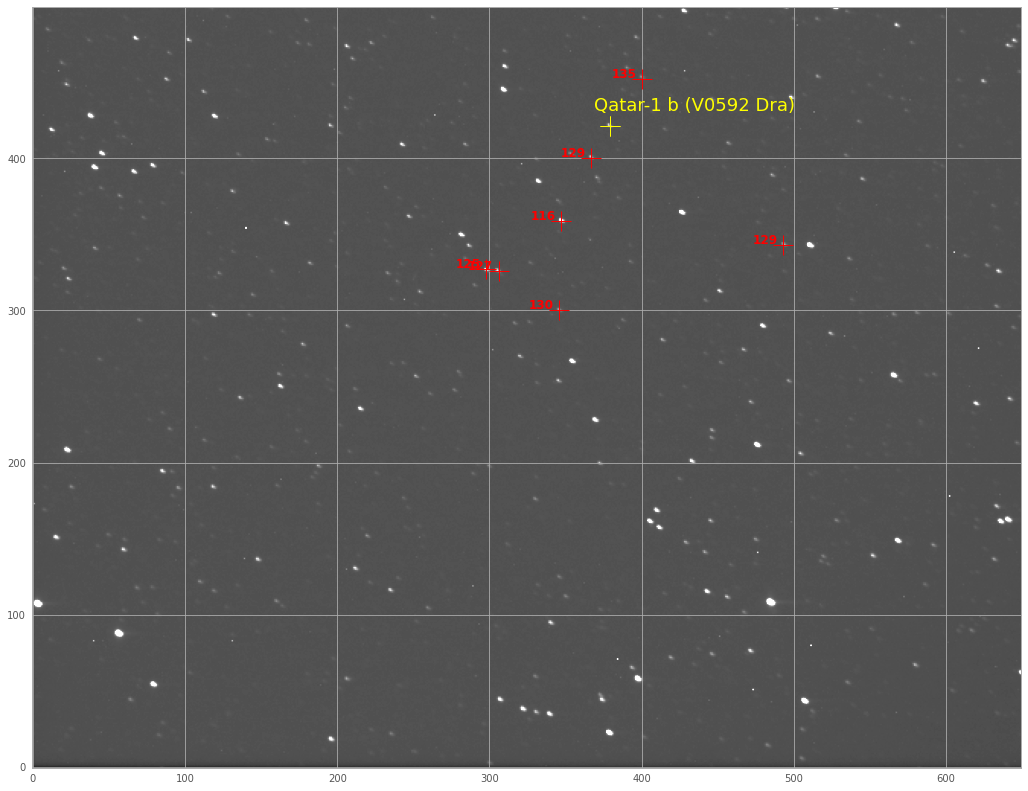

In [ ]:
def find_comps(searchbox, centerRA, centerDec, target_coords, wrld, MagLimit):
  # Search for comp stars
  data = {}
  data['format'] = 'json'
  data['fov'] = searchbox
  data['ra'] = centerRA
  data['dec'] = centerDec
  data['maglimit'] = MagLimit

  url = 'https://app.aavso.org/vsp/api/chart/'
  url_values = urllib.parse.urlencode(data)
  full_url = url + '?' + url_values
  respj = requests.get(full_url)
  resj = respj.json()
  list(resj)
  CheckError = resj.get('errors','No Errors') 
  if CheckError != 'No Errors':
    print('Search Error')
  else:
    kval = resj.get('photometry')
    CompStarList = []
    CompStarXY = []
    dist_from_target = []
    for compk in kval:
      compRA = compk.get('ra')
      compDEC = compk.get('dec')
      compAUID = compk.get('auid')
      compLabel = compk.get('label')
      skystar = SkyCoord(compRA, compDEC, frame='fk5',unit=(u.hourangle,u.deg))
      stary, starx = wrld.world_to_array_index(skystar)
      compv = compk.get('bands')
      for bandk in compv:
        if bandk.get('band') == 'V':
          Vmag = float(bandk.get('mag'))
        if bandk.get('band') == 'B':
          Bmag = float(bandk.get('mag'))
      thisComp = {}
      thisComp['Label'] = compLabel
      thisComp['AUID'] = compAUID
      thisComp['FITS_x'] = starx
      thisComp['FITS_y'] = stary
      thisComp['RA'] = compRA
      thisComp['Dec'] = compDEC
      thisComp['Vmag'] = Vmag
      thisComp['Bmag'] = Bmag
      thisXY = [starx,stary]
      CompStarXY.append(thisXY)
      CompStarList.append(thisComp)
      dist_from_target.append(math.sqrt(((target_coords[0]-starx)**2) + ((target_coords[1]-stary)**2)))

  sorted_CompStarXY = [CompStarXY for _,CompStarXY in sorted(zip(dist_from_target,CompStarXY), key=lambda f:f[0])]      
  sorted_CompStarList = [CompStarList for _,CompStarList in sorted(zip(dist_from_target,CompStarList), key=lambda f:f[0])]      

  new_CompStarXY, new_CompStarList = [], []
  for i in range(len(CompStarXY)):
    if i > 9:   # EXOTIC will not allow more than 10 comps: if more than 10 choose the closest 10 to target
      break
    new_CompStarXY.append(sorted_CompStarXY[i])
    new_CompStarList.append(sorted_CompStarList[i])

  return(new_CompStarList, new_CompStarXY)

######################################################################

def find_pixel_coords(InputFITS, pixelScale, SearchSize, targetRA, targetDec, MagLimit):
  image_params = {}
  target_coords = []
  varStarList = []
  foundTarget = False

  infits = fits.open(InputFITS)
  wrld = WCS(infits[0].header)
  image_data = infits[0].data

  fdims = wrld.pixel_shape
  mind = fdims[0]
  if fdims[1] < mind:
    mind = fdims[1]
  if pixelScale > 0:
    searchbox = int(((mind*pixelScale)/60) - 1)
  else:
    searchbox = SearchSize
  if searchbox > 300:
    searchbox = 300
  xcenterpix = fdims[0]/2
  ycenterpix = fdims[1]/2
  centercoords = wrld.pixel_to_world(xcenterpix,ycenterpix)
  centerRA = centercoords.ra.degree
  centerDec = centercoords.dec.degree
  url = 'http://www.aavso.org/vsx/index.php'
  data = {}
  data['view'] = 'query.votable'
  data['filter'] = '0,1'

  # Search by the given coordinates
  data['format'] = 'd'
  data['geom'] = 'b'
  data['size'] = searchbox
  data['order'] = '9'
  data['coords'] = centercoords.to_string('decimal')
  resj = get_vsx_data(url,params=data)
  if len(resj) > 0:
    for star in resj:
      StarName = 'no match'
      VSX_UID = 'no match'
      vcoords = 'no match'
      for k,v in star.items():
        if k == 'name':
          StarName = v
        if k == 'auid':
          VSX_UID = v
        if k == 'maxMag':
          VSX_Mag = v
        if k == 'maxPass':
          VSX_Band = v
        if k == 'radec2000':
          vcoords = v.split(",")
        if k == 'varType':
          varType = v
      skystar = SkyCoord(vcoords[0], vcoords[1], frame='fk5', unit='deg')
      stary, starx = wrld.world_to_array_index(skystar)
      thisStar = {}
      thisStar['StarName'] = StarName
      thisStar['FITS_x'] = starx
      thisStar['FITS_y'] = stary
      thisStar['AUID'] = VSX_UID
      thisStar['RA'] = vcoords[0]
      thisStar['Dec'] = vcoords[1]
      thisStar['mag'] = VSX_Mag
      thisStar['band'] = VSX_Band
      thisStar['varType'] = varType
      thisStar['isTarget'] = False

      if (abs(float(vcoords[0]) - targetRA)) < 0.0005 and (abs(float(vcoords[1]) - targetDec)) < 0.0005:
        thisStar['isTarget'] = True
        foundTarget = True
        target_coords = [starx,stary]

      varStarList.append(thisStar)

  CompStarList, CompStarXY = [], []
  if foundTarget: 
    CompStarList, CompStarXY = find_comps(searchbox, centerRA, centerDec, target_coords, wrld, MagLimit)

  image_params= {"target_coords": target_coords, "varStarList": varStarList, "searchbox": searchbox, 
                 "centerRA": centerRA, "centerDec": centerDec, "wrld": wrld, "image_data": image_data, 
                 "CompStarList": CompStarList, "CompStarXY": CompStarXY }
  return(image_params)

######################################################################

def display_image_with_labels(target, img_params, output_fov_file, comp_used):
  target_coords, CompStarXY, image_data = img_params["target_coords"], img_params["CompStarXY"], img_params["image_data"]

#  print(f"{target}: {target_coords}\nComps: {CompStarXY}\n")

  norm = ImageNormalize(image_data, interval=ZScaleInterval(), stretch=SquaredStretch())

  if "vmin" in img_params.keys() and "vmax" in img_params.keys():
    vmi, vma = img_params["vmin"], img_params["vmax"]
    norm = ImageNormalize(image_data, interval=ZScaleInterval(), stretch=SquaredStretch(), vmin=vmi, vmax=vma)

  fig = plt.figure(figsize=(21,14))
  ax = fig.add_subplot(111)

  plt.imshow(image_data, norm=norm, origin='lower', cmap='Greys_r', interpolation=None)

  for thisStar in img_params["varStarList"]:
    if float(thisStar.get('mag')) < MagLimit:
      xpos = thisStar.get('FITS_x')
      ypos = thisStar.get('FITS_y')
      ylabel = ypos + 10
      xlabel = xpos - 10
      if thisStar["isTarget"]:
        ax.plot(xpos, ypos, marker='+',color='yellow', ms=20)
        ax.text(xlabel, ylabel, str(f"{target} ({thisStar.get('StarName')})"), color = 'yellow', fontsize=18)
      else:
        ax.plot(xpos, ypos, marker='+',color='lime', ms=20)
        ax.text(xlabel, ylabel, thisStar.get('StarName'), color = 'lime', fontsize=14)
#        print(f"** Note the secondary variable at {xpos}, {ypos}")

  for thisStar in img_params["CompStarList"]:
    comp_color='red'
    fontsize=12
    weight='bold'
    label = thisStar.get('Label')
    xpos = thisStar.get('FITS_x')
    ypos = thisStar.get('FITS_y')
    if "x" in comp_used.keys():
      if (comp_used["x"] == xpos and comp_used["y"] == ypos):
        comp_color='pink'
        fontsize=16
        weight='normal'
        label = thisStar.get('AUID') + " (" + str(thisStar.get('Label')) + ")"
    ylabel = ypos + 1
    xlabel = xpos - 20
    ax.plot(xpos, ypos, marker='+',color=comp_color, ms=20)
    ax.text(xlabel, ylabel, label, color=comp_color, fontsize=fontsize, fontweight=weight)

  ax.plot(target_coords[0], target_coords[1], marker='+',color='yellow', ms=20)
  fig.savefig(output_fov_file, bbox_inches = 'tight', pad_inches = 0.1)

######################################################################

def make_MObs_inits(inits_file_path, fits_dir, output_dir, darks_dir, planetary_params, image_params, obs_date):

  with open(inits_file_path, 'w') as inits_file:
    inits_file.write("""
{
  %s,
    "user_info": {
            "Directory with FITS files": "%s",
            "Directory to Save Plots": "%s",
            "Directory of Flats": null,
            "Directory of Darks": "%s",
            "Directory of Biases": null,

            "AAVSO Observer Code (N/A if none)": "MObs",
            "Secondary Observer Codes (N/A if none)": "TKAA",

            "Observation date": "%s",
            "Obs. Latitude": "+37.04",
            "Obs. Longitude": "-110.73",
            "Obs. Elevation (meters)": 2606,
            "Camera Type (CCD or DSLR)": "CCD",
            "Pixel Binning": "1x1",
            "Filter Name (aavso.org/filters)": "V",
            "Observing Notes": "N/A",

            "Plate Solution? (y/n)": "y",
            "Align Images? (y/n)": "y",

            "Target Star X & Y Pixel": %s,
            "Comparison Star(s) X & Y Pixel": %s
    },    
    "optional_info": {
            "Pixel Scale (Ex: 5.21 arcsecs/pixel)": null,
            "Filter Minimum Wavelength (nm)": null,
            "Filter Maximum Wavelength (nm)": null
    }
}
""" % (planetary_params, fits_dir, output_dir, darks_dir, obs_date, 
       image_params["target_coords"], image_params["CompStarXY"]))
  
########################################################################

def make_AAVSO_comp_inits(pixelScale, SearchSize, MagLimit, initsdir, Platesolved_images_dir, path_to_images, EXOTIC_output_dirs, p_param_dict):
  imgs = [f for f in sorted(os.listdir(Platesolved_images_dir)) if re.search(r"\.FITS?$", f, re.IGNORECASE)]
  target = p_param_dict["Planet Name"]  
  planetary_params = p_param_dict["planetary_params"]

  num_done = 0
  for img in imgs:
    obs_date = img[0:10]

    inits_filepath = os.path.join(initsdir, obs_date+".json")

    if os.path.isfile(inits_filepath):
      print(f"(Already have an inits file for {obs_date}; skipping)")
      continue

    if obs_date == "2012-03-30" or obs_date == "2020-10-03":
      continue

    InputFITS = os.path.join(Platesolved_images_dir, img)
    print(f"Finding {target} and comps brighter than {MagLimit} in {img}")
    img_params = find_pixel_coords(InputFITS, pixelScale, SearchSize, targetRA, targetDec, MagLimit)
    if len(img_params["target_coords"]) == 0:
      print(f"Couldn't find {target} in {img}!")
      continue

    fits_dir = os.path.join(path_to_images, obs_date, "images")
    darks_dir = os.path.join(path_to_images, obs_date, "darks")
    output_dir = os.path.join(EXOTIC_output_dirs, obs_date)
    if not os.path.isdir(output_dir):
      os.mkdir(output_dir)
    display_image_with_labels(target, img_params, os.path.join(output_dir, target+"_"+obs_date+".png"), {})
    make_MObs_inits(inits_filepath, fits_dir, output_dir, darks_dir, planetary_params, img_params, obs_date)
    num_done += 1
    if num_done > 5:
      break

########################################################################

def get_comp(aavso_filepath):
#  print(f"In get_comp: aavso_filepath {aavso_filepath}")
  found_comp = False
  with open(aavso_filepath, 'r') as aavso:
    for line in aavso:
      m = re.search("#COMP_STAR-XC=\[\]", line)   # Return empty strings if no comp star was used.
      if m:
        return("no comp,no comp,no comp,no comp")
      m = re.search("#COMP_STAR-XC=\[\{\"ra\"\: \"(\d+\.\d+)\", \"dec\"\: \"([+-]?\d+\.\d+)\", \"x\"\: \"(\d+)\", \"y\"\: \"(\d+)\"\}\]", line)
      if m:
        comp_ra, comp_dec, comp_x, comp_y = m.group(1), m.group(2), m.group(3), m.group(4)
#        print (f"Got comp_ra {comp_ra}, comp_dec {comp_dec}, comp_x {comp_x}, comp_y {comp_y}")
        return(f"{comp_ra},{comp_dec},{comp_x},{comp_y}")
      m = re.search("#COMP_STAR-XC=\[\{\"ra\"\: null, \"dec\"\: null, \"x\"\: \"(\d+)\", \"y\"\: \"(\d+)\"\}\]", line)
      if m:
        comp_ra, comp_dec, comp_x, comp_y = "null", "null", m.group(1), m.group(2)
        return(f"{comp_ra},{comp_dec},{comp_x},{comp_y}")
  
########################################################################

def find_comps_used (pixelScale, SearchSize, MagLimit, EXOTIC_output_dirs, Platesolved_images_dir, targetRA, targetDec):
  comps_used = {}
  dirs = [d for d in sorted(os.listdir(EXOTIC_output_dirs)) if os.path.isdir(os.path.join(EXOTIC_output_dirs,d))]
  for d in dirs:
    if d != "2014-09-12":
      continue
    p = os.path.join(EXOTIC_output_dirs,d)
    files = [f for f in sorted(os.listdir(p)) if os.path.isfile(os.path.join(p,f))]
    image_params = {}
    for f in files:
      if re.search(r"^AAVSO", f):
        aavso_filepath = os.path.join(p, f)
        comps = get_comp(aavso_filepath)
        comp_ra, comp_dec, comp_x, comp_y = comps.split(",")
        comp_name = ""
        if comp_x == "no comp":
          comp_x, comp_y, comp_ra, comp_dec = 0, 0, 0.0, 0.0 
        else:
          image_params = find_pixel_coords(os.path.join(Platesolved_images_dir,d+".fits"), pixelScale, SearchSize, targetRA, targetDec, MagLimit)
          CompStarList = image_params["CompStarList"]
          for s in CompStarList:
            if s["FITS_x"] == int(comp_x) and s["FITS_y"] == int(comp_y):
              comp_ra, comp_dec, comp_name = s["RA"], s["Dec"], s["AUID"]
              coord = comp_ra+" "+comp_dec
              c = SkyCoord(coord, unit=(u.hourangle, u.deg))
              comp_ra, comp_dec = c.ra.deg, c.dec.deg
        if comp_ra == "null":
          comp_ra, comp_dec = 0.0, 0.0
        comp_dict = {"x": int(comp_x), "y": int(comp_y), "RA": float(comp_ra), "Dec": float(comp_dec), "Name": comp_name}
        comps_used[d] = comp_dict
        output_fov_file = os.path.join(p,str(f"FOV_AAVSO_{d}.png"))
        display_image_with_labels(target, image_params, output_fov_file, comp_dict)
#        break
#      break
#    break

  for date in sorted(comps_used.keys()):
    c = comps_used[date]
    compx, compy, compRA, compDec, comp_name = c["x"], c["y"], c["RA"], c["Dec"], c["Name"]
    compRA = round(compRA, 4)
    compDec = round(compDec, 4)
    print(f"{date},{compx},{compy},{compRA},{compDec},{comp_name}")

  return(comps_used)
        
########################################################################

# pixelScale will be used to calculate the search size.
# If you don't know it, set it to zero or a negative number and 
# the search size will use the SearchSize parameter
pixelScale = 0

# SearchSize is the comp field in arcminutes (30 corresponds to AAVSO Chart Field E). 
# It is only used if pixelScale is not set
SearchSize = 35

# MagLimit is the maximum magnitude for plotting variable stars 
MagLimit = 13.5

prefix = "/content/drive/My Drive/"
path_to_analysis = os.path.join(prefix, "2021 Tres-1b inits")  # Subdirs are "AAVSO_comps_inits_files", "Platesolved_first_images", "EXOTIC_output"
path_to_images = os.path.join(prefix, "2021 Tres-1b")  # Subdirs are YYYY-MM-DD, with each having subdirs "images" and "darks"
target = "Tres-1b"

initsdir = os.path.join(path_to_analysis, "AAVSO_comps_inits_files/")
Platesolved_images_dir = os.path.join(path_to_analysis, "Platesolved_first_images/")
EXOTIC_output_dirs = os.path.join(path_to_analysis, "EXOTIC_output/")

#make_AAVSO_comp_inits(pixelScale, SearchSize, MagLimit, initsdir, Platesolved_images_dir, path_to_images, EXOTIC_output_dirs, p_param_dict)

#comps_used = find_comps_used (pixelScale, SearchSize, MagLimit, EXOTIC_output_dirs, Platesolved_images_dir, targetRA, targetDec)

target, obs_date = "Qatar-1 b", "2018-11-21"
InputFITS = "/content/drive/My Drive/2021 Qatar-1b inits/Platesolved_first_images/"+obs_date+".fits"
output_dir = "/content/drive/My Drive/2021 Qatar-1b inits/EXOTIC_output/"+obs_date+"/"
img_params = find_pixel_coords(InputFITS, pixelScale, SearchSize, targetRA, targetDec, MagLimit)
img_params["vmin"] = 50
img_params["vmax"] = 900
if len(img_params["target_coords"]) == 0:
  print(f"Couldn't find {target} in {img}!")
display_image_with_labels(target, img_params, os.path.join(output_dir, target+"_"+obs_date+".png"), {})

In [ ]:
#@title Scratch 1
def get_plate_solution(filepath, output_directory, dirname):
  print(f"Plate-solving {filepath}")
  wcs_obj = PlateSolution(file=filepath, directory=output_directory)
  wcs_file = wcs_obj.plate_solution()
  platesolved_filepath = os.path.join(output_directory, "wcs.fits")
  new_platesolved_filepath = os.path.join(output_directory, dirname+".fits")
  if os.path.isfile(platesolved_filepath):
    os.rename(platesolved_filepath, new_platesolved_filepath)
  else:
    print(f"No plate solution for {dirname}, sorry!")  

################################################

img_folder = "/content/drive/My Drive/Qatar-1b-transits"
i_path = "/content/drive/My Drive/2021 Qatar-1b inits/AAVSO_comps"
platesolved_path = "/content/drive/My Drive/2021 Qatar-1b inits/Platesolved/"

inits_paths = []
for i in range(7):
  inits_paths.append(os.path.join(i_path, "run"+str(i)))
inits_paths.append(os.path.join(i_path, "run4", "done"))

dates_with_inits = {}
for p in inits_paths:
  files = [f for f in sorted(os.listdir(p)) if os.path.isfile(os.path.join(p,f))]
  for f in files:
    m = re.search(r"(\d\d\d\d\-\d\d\-\d\d)( \(1\))?.json", f)
    if m:
      dates_with_inits[m.group(1)] = True
    else:
      print(f"file {f} in dir {p} didn't match")
#print(dates_with_inits)

dirs = [d for d in sorted(os.listdir(img_folder)) if os.path.isdir(os.path.join(img_folder,d))]
for d in dirs:
  if not re.search(r"\d\d\d\d\-\d\d\-\d\d", d):
    continue
  if d not in dates_with_inits.keys():
    imgs = [f for f in sorted(os.listdir(os.path.join(img_folder, d, "images"))) if re.search(r"FITS?$", f, re.IGNORECASE)]
    num_imgs = len(imgs)
    print(f"{d}: {num_imgs} images")
    if num_imgs > 40:
      first_image_filepath = os.path.join(img_folder, d, "images", imgs[0])
      print(f"Will try platesolving {first_image_filepath}")
#      get_plate_solution(first_image_filepath, platesolved_path, d)


In [ ]:
#@title Scratch 2
def read_file_into_string(f):
  s = ""
  with open(f, 'r') as i_file:
    for line in i_file:
#      print(line)
      s = s+line
  return(s)

date = "2011-05-27"
f1 = "/content/drive/My Drive/2021 Qatar-1b inits/AAVSO_comps/run0/"+date+".json"
f2 = "/content/drive/My Drive/2021 Qatar-1b inits/AAVSO_comps/run0/"+date+" (1).json"

s1 = read_file_into_string(f1)
s2 = read_file_into_string(f2)

if (s1 != s2):
  print("s1\n\n"+s1+"\n\ns2\n\n"+s2)
else:
  print("The file contents are identical.")

In [ ]:
#@title Scratch 3

for d in dirs:
  m = re.search(r"(\d\d\d\d)\-\d\d\-\d\d", d)
  if m:
    if int(m.group(1)) > 2019:
      print(m.group(1))
      platesolved_first_image = os.path.join(folder, d, "wcs.fits")
      if os.path.isfile(platesolved_first_image):
        platesolved_destination_path = "/content/drive/My Drive/2021 Qatar-1b inits/Platesolved/"+d+".fits"
        print(platesolved_destination_path)
        os.rename(platesolved_first_image, platesolved_destination_path)

In [ ]:
#@title Scratch 4 (count dirs, multiple runs)
def multiple_runs(p):
  files = [f for f in sorted(os.listdir(p)) if os.path.isfile(os.path.join(p,f))]

  dates = {}
  fdates = {}

  for f in files:
    fpath = os.path.join(p, f)
    fname = pathlib.Path(fpath)
    mtime = datetime.datetime.fromtimestamp(fname.stat().st_mtime)
    if not mtime in dates.keys():
      dates[mtime] = []
    dates[mtime].append(f)

    if mtime.day == 14:
      print(f"Alert!! {p}")

    m = re.search(r"(.+)(\d\d\d\d\-\d\d\-\d\d)(.+)", f)
    if not m:
      print(f"File {f} doesn't match!")
    fwodate = m.group(1)+m.group(3)

    if not fwodate in fdates.keys():
      fdates[fwodate] = []
    fdates[fwodate].append(mtime)
  
  multiple_versions = False
  for f in sorted(fdates.keys()):
    dates = fdates[f]
    if len(dates) > 1:
#      print(f"{f}: {len(dates)} versions: {dates}")
      multiple_versions = True
  return(multiple_versions)

################################################

import datetime
import pathlib
p = "/content/drive/My Drive/2021 Tres-1b/"

dirs = [d for d in sorted(os.listdir(p)) if os.path.isdir(os.path.join(p,d))]

dir_count = 0
for d in dirs:
  dir_count += 1
  images = [f for f in sorted(os.listdir(os.path.join(p,d,"images"))) if os.path.isfile(os.path.join(p,d,"images",f))]
  num_images = len(images)
  if num_images > 60:
    continue
  print(f"{d}: {num_images} images")
print(f"Count {dir_count} folders")
#  dirpath = os.path.join(p, d)
#  multiple_versions = multiple_runs(dirpath)
#  if (multiple_versions):
#    print(f"{d}: multiple verisons {multiple_versions}")


In [ ]:
#@title Scratch 5 (Copy files within Gdrive)
p = "/content/drive/MyDrive/0.Teams/2020.teams/1.1.Quinn.Paige/K4/QR Folder/Images/Tres-1b-transits/"
new_p = "/content/drive/MyDrive/2021 Tres-1b/"
dirs = [d for d in sorted(os.listdir(p)) if os.path.isdir(os.path.join(p,d))]
for d in dirs:
  images = [f for f in sorted(os.listdir(os.path.join(p,d,"images"))) if os.path.isfile(os.path.join(p,d,"images",f))]
  num_images = len(images)
  print(f"{d}: {num_images} images")
  if num_images > 60:
    if not os.path.isdir(os.path.join(new_p, d)):
      os.mkdir(os.path.join(new_p, d))
    if not os.path.isdir(os.path.join(new_p, d, "images")):
      os.mkdir(os.path.join(new_p, d, "images"))
    if not os.path.isdir(os.path.join(new_p, d, "darks")):
      os.mkdir(os.path.join(new_p, d, "darks"))
    for img in images:
      if not os.path.isfile(os.path.join(new_p, d, "images", img)):
        copyfile(os.path.join(p, d, "images", img), os.path.join(new_p, d, "images", img))
    darks = [f for f in sorted(os.listdir(os.path.join(p,d,"darks"))) if os.path.isfile(os.path.join(p,d,"darks",f))]
    for dark in darks:
      if not os.path.isfile(os.path.join(new_p, d, "darks", img)):
        copyfile(os.path.join(p, d, "darks", img), os.path.join(new_p, d, "darks", img))     